In [10]:
import sympy
import matplotlib.pyplot as plt
import numpy as np
from triangle import triangulate
import symfem

import matplotlib.colors as mcolors
from random import sample, choice
from tqdm import tqdm
from IPython.display import display
from utils import (
    get_middle_indices,
)

In [11]:
X, Y, x, y, x_1, y_1, x_2, y_2, x_3, y_3, p_1, p_2, p_3 = sympy.symbols(
    "X Y x y x_1 y_1 x_2 y_2 x_3 y_3 p_1 p_2 p_3"
)

In [12]:
triangle_sym = np.array(
    [
        [x_1, y_1],
        [x_2, y_2],
        [x_3, y_3],
    ]
)

In [13]:
argyris_basis = symfem.create_element("triangle", "Argyris", 5)
argyris_basis_reference = argyris_basis.get_basis_functions()

In [14]:
def orient(arg):
    
    indices = np.argsort(arg[:3])
    oriented = np.concatenate([arg[:3][indices], arg[3:][indices]])
    
    return oriented

In [15]:
MAP = argyris_basis.reference.get_map_to(triangle_sym)
INV_MAP = argyris_basis.reference.get_inverse_map_to(triangle_sym)


In [177]:
def transform_basis(points, triangles, tindex):
    
    MAP = argyris_basis.reference.get_map_to(triangle_sym)
    INV_MAP = argyris_basis.reference.get_inverse_map_to(triangle_sym)
    
    rot = np.array([
        [+0, +1],
        [-1, +0]
    ])

    oriented_triangle = orient(triangles[tindex])
    trng = points[oriented_triangle]

    u = INV_MAP[0].subs(
        {
            x_1: trng[0, 0],
            x_2: trng[1, 0],
            x_3: trng[2, 0],
            y_1: trng[0, 1],
            y_2: trng[1, 1],
            y_3: trng[2, 1],
        }
    )

    v = INV_MAP[1].subs(
        {
            x_1: trng[0, 0],
            x_2: trng[1, 0],
            x_3: trng[2, 0],
            y_1: trng[0, 1],
            y_2: trng[1, 1],
            y_3: trng[2, 1],
        }
    )

    J = sympy.Matrix([u, v]).jacobian([x, y])
    

    THETA = sympy.Matrix(
        [
            [u.diff(x) ** 2, 2 * u.diff(x) * v.diff(x), v.diff(x) ** 2],
            [
                u.diff(y) * u.diff(x),
                u.diff(y) * v.diff(x) + u.diff(x) * v.diff(y),
                v.diff(x) * v.diff(y),
            ],
            [u.diff(y) ** 2, 2 * u.diff(y) * v.diff(y), v.diff(y) ** 2],
        ]
    ).inv()

    l1 = (((x_2 - x_3) ** 2 + (y_2 - y_3) ** 2) ** 0.5).subs(
        {
            x_1: trng[0, 0],
            x_2: trng[1, 0],
            x_3: trng[2, 0],
            y_1: trng[0, 1],
            y_2: trng[1, 1],
            y_3: trng[2, 1],
        }
    )

    l2 = (((x_1 - x_3) ** 2 + (y_1 - y_3) ** 2) ** 0.5).subs(
        {
            x_1: trng[0, 0],
            x_2: trng[1, 0],
            x_3: trng[2, 0],
            y_1: trng[0, 1],
            y_2: trng[1, 1],
            y_3: trng[2, 1],
        }
    )

    l3 = (((x_1 - x_2) ** 2 + (y_1 - y_2) ** 2) ** 0.5).subs(
        {
            x_1: trng[0, 0],
            x_2: trng[1, 0],
            x_3: trng[2, 0],
            y_1: trng[0, 1],
            y_2: trng[1, 1],
            y_3: trng[2, 1],
        }
    )

    t1 = trng[2] - trng[1]
    t1 = t1 / np.linalg.norm(t1)
    n1 = rot @ t1
    

    t2 = trng[2] - trng[0]
    t2 = t2 / np.linalg.norm(t2)
    n2 = rot @ t2

    
    t3 = trng[1] - trng[0]
    t3 = t3 / np.linalg.norm(t3)
    n3 = rot @ t3


    G1 = sympy.Matrix([[*n1], [*t1]])
    G2 = sympy.Matrix([[*n2], [*t2]])
    G3 = sympy.Matrix([[*n3], [*t3]])

    
    G1_hat = sympy.Matrix(
        [
            [-np.sqrt(1 / 2), -np.sqrt(1 / 2)],
            [-np.sqrt(1 / 2), +np.sqrt(1 / 2)],
        ]
    )

    G2_hat = sympy.Matrix(
        [
            [-1, +0],
            [+0, +1],
        ]
    )

    G3_hat = sympy.Matrix(
        [
            [+0, +1], 
            [+1, +0]
        ]
    )

    B1 = G1_hat @ J.inv().T @ G1.T
    B2 = G2_hat @ J.inv().T @ G2.T
    B3 = G3_hat @ J.inv().T @ G3.T


    tau_1 = sympy.Matrix(
        [
            t1[0] ** 2,
            2 * t1[0] * t1[1],
            t1[1] ** 2,
        ]
    )

    tau_2 = sympy.Matrix(
        [
            t2[0] ** 2,
            2 * t2[0] * t2[1],
            t2[1] ** 2,
        ]
    )

    tau_3 = sympy.Matrix(
        [
            t3[0] ** 2,
            2 * t3[0] * t3[1],
            t3[1] ** 2,
        ]
    )

    ## Function values at the nodes
    F_1 = (
        argyris_basis_reference[0]
        - 15 / (8 * l2) * B2.row(0)[1] * argyris_basis_reference[19]
        - 15 / (8 * l3) * B3.row(0)[1] * argyris_basis_reference[20]
    )

    F_2 = (
        argyris_basis_reference[6]
        - 15 / (8 * l1) * B1.row(0)[1] * argyris_basis_reference[18]
        + 15 / (8 * l3) * B3.row(0)[1] * argyris_basis_reference[20]
    )

    F_3 = (
        argyris_basis_reference[12]
        + 15 / (8 * l1) * B1.row(0)[1] * argyris_basis_reference[18]
        + 15 / (8 * l2) * B2.row(0)[1] * argyris_basis_reference[19]
    )
    F_1 = F_1.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v).as_sympy()
    F_2 = F_2.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v).as_sympy()
    F_3 = F_3.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v).as_sympy()

    ## Function derivative wit respect to x
    DX_1 = (
        + J.inv().T.row(0)[0] * argyris_basis_reference[1]
        + J.inv().T.row(1)[0] * argyris_basis_reference[2]
        - 7 / 16 * t2[0] * B2.row(0)[1] * argyris_basis_reference[19]
        - 7 / 16 * t3[0] * B3.row(0)[1] * argyris_basis_reference[20]
    )

    DX_2 = (
        + J.inv().T.row(0)[0] * argyris_basis_reference[7]
        + J.inv().T.row(1)[0] * argyris_basis_reference[8]
        - 7 / 16 * t1[0] * B1.row(0)[1] * argyris_basis_reference[18]
        - 7 / 16 * t3[0] * B3.row(0)[1] * argyris_basis_reference[20]
    )

    DX_3 = (
        + J.inv().T.row(0)[0] * argyris_basis_reference[13]
        + J.inv().T.row(1)[0] * argyris_basis_reference[14]
        - 7 / 16 * t1[0] * B1.row(0)[1] * argyris_basis_reference[18]
        - 7 / 16 * t2[0] * B2.row(0)[1] * argyris_basis_reference[19]
    )

    DX_1 = DX_1.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DX_2 = DX_2.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DX_3 = DX_3.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)

    ## Function derivative wit respect to y

    DY_1 = (
        J.inv().T.row(0)[1] * argyris_basis_reference[1]
        + J.inv().T.row(1)[1] * argyris_basis_reference[2]
        - 7 / 16 * t2[1] * B2.row(0)[1] * argyris_basis_reference[19]
        - 7 / 16 * t3[1] * B3.row(0)[1] * argyris_basis_reference[20]
    )

    DY_2 = (
        J.inv().T.row(0)[1] * argyris_basis_reference[7]
        + J.inv().T.row(1)[1] * argyris_basis_reference[8]
        - 7 / 16 * t1[1] * B1.row(0)[1] * argyris_basis_reference[18]
        - 7 / 16 * t3[1] * B3.row(0)[1] * argyris_basis_reference[20]
    )

    DY_3 = (
        J.inv().T.row(0)[1] * argyris_basis_reference[13]
        + J.inv().T.row(1)[1] * argyris_basis_reference[14]
        - 7 / 16 * t1[1] * B1.row(0)[1] * argyris_basis_reference[18]
        - 7 / 16 * t2[1] * B2.row(0)[1] * argyris_basis_reference[19]
    )

    DY_1 = DY_1.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DY_2 = DY_2.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DY_3 = DY_3.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)

    ## Function second derivative wit respect to x
    DXX_1 = (
        + THETA.row(0)[0] * argyris_basis_reference[3]
        + THETA.row(1)[0] * argyris_basis_reference[4]
        + THETA.row(2)[0] * argyris_basis_reference[5]
        - l2 / 32 * tau_2[0] * B2.row(0)[1] * argyris_basis_reference[19]
        - l3 / 32 * tau_3[0] * B3.row(0)[1] * argyris_basis_reference[20]
    )

    DXX_2 = (
        + THETA.row(0)[0] * argyris_basis_reference[9]
        + THETA.row(1)[0] * argyris_basis_reference[10]
        + THETA.row(2)[0] * argyris_basis_reference[11]
        - l1 / 32 * tau_1[0] * B1.row(0)[1] * argyris_basis_reference[18]
        + l3 / 32 * tau_3[0] * B3.row(0)[1] * argyris_basis_reference[20]
    )

    DXX_3 = (
        + THETA.row(0)[0] * argyris_basis_reference[15]
        + THETA.row(1)[0] * argyris_basis_reference[16]
        + THETA.row(2)[0] * argyris_basis_reference[17]
        + l1 / 32 * tau_1[0] * B1.row(0)[1] * argyris_basis_reference[18]
        + l2 / 32 * tau_2[0] * B2.row(0)[1] * argyris_basis_reference[19]
    )

    DXX_1 = DXX_1.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DXX_2 = DXX_2.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DXX_3 = DXX_3.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)

    ## Function second derivative wit respect to xy
    DXY_1 = (
        + THETA.row(0)[1] * argyris_basis_reference[3]
        + THETA.row(1)[1] * argyris_basis_reference[4]
        + THETA.row(2)[1] * argyris_basis_reference[5]
        - l2 / 32 * tau_2[1] * B2.row(0)[1] * argyris_basis_reference[19]
        - l3 / 32 * tau_3[1] * B3.row(0)[1] * argyris_basis_reference[20]
    )

    DXY_2 = (
        + THETA.row(0)[1] * argyris_basis_reference[9]
        + THETA.row(1)[1] * argyris_basis_reference[10]
        + THETA.row(2)[1] * argyris_basis_reference[11]
        - l1 / 32 * tau_1[1] * B1.row(0)[1] * argyris_basis_reference[18]
        + l3 / 32 * tau_3[1] * B3.row(0)[1] * argyris_basis_reference[20]
    )

    DXY_3 = (
        + THETA.row(0)[1] * argyris_basis_reference[15]
        + THETA.row(1)[1] * argyris_basis_reference[16]
        + THETA.row(2)[1] * argyris_basis_reference[17]
        + l1 / 32 * tau_1[1] * B1.row(0)[1] * argyris_basis_reference[18]
        + l2 / 32 * tau_2[1] * B2.row(0)[1] * argyris_basis_reference[19]
    )

    DXY_1 = DXY_1.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DXY_2 = DXY_2.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DXY_3 = DXY_3.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)

    ## Function second derivative wit respect to y
    DYY_1 = (
        + THETA.row(0)[2] * argyris_basis_reference[3]
        + THETA.row(1)[2] * argyris_basis_reference[4]
        + THETA.row(2)[2] * argyris_basis_reference[5]
        - l2 / 32 * tau_2[2] * B2.row(0)[1] * argyris_basis_reference[19]
        - l3 / 32 * tau_3[2] * B3.row(0)[1] * argyris_basis_reference[20]
    )

    DYY_2 = (
        + THETA.row(0)[2] * argyris_basis_reference[9]
        + THETA.row(1)[2] * argyris_basis_reference[10]
        + THETA.row(2)[2] * argyris_basis_reference[11]
        - l1 / 32 * tau_1[2] * B1.row(0)[1] * argyris_basis_reference[18]
        + l3 / 32 * tau_3[2] * B3.row(0)[1] * argyris_basis_reference[20]
    )

    DYY_3 = (
        + THETA.row(0)[2] * argyris_basis_reference[15]
        + THETA.row(1)[2] * argyris_basis_reference[16]
        + THETA.row(2)[2] * argyris_basis_reference[17]
        + l1 / 32 * tau_1[2] * B1.row(0)[1] * argyris_basis_reference[18]
        + l2 / 32 * tau_2[2] * B2.row(0)[1] * argyris_basis_reference[19]
    )

    DYY_1 = DYY_1.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DYY_2 = DYY_2.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DYY_3 = DYY_3.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)

    DN_1 = B1.row(0)[0] * argyris_basis_reference[18]
    DN_2 = B2.row(0)[0] * argyris_basis_reference[19]
    DN_3 = B3.row(0)[0] * argyris_basis_reference[20]

    DN_1 = DN_1.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DN_2 = DN_2.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)
    DN_3 = DN_3.subs(x, X).subs(y, Y).subs(X, u).subs(Y, v)

    return [
        F_1,F_2,F_3,
        DX_1,DX_2,DX_3,
        DY_1,DY_2,DY_3,
        DXX_1,DXX_2,DXX_3,
        DXY_1,DXY_2,DXY_3,
        DYY_1,DYY_2,DYY_3,
        DN_1,DN_2,DN_3,
    ], oriented_triangle

In [178]:
t = np.linspace(0, 2 * np.pi, 9, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T
seg = np.array(
    [[j, j + 1] for j in range(points.shape[0] - 1)] + [[points.shape[0] - 1, 0]]
)

In [179]:
cndt = triangulate({"vertices": points, "segments": seg}, opts="pq30a0.32neo2")
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
edges = cndt["edges"]
vertex_maker_is_boundary = cndt["vertex_markers"]

### Separate middle points

In [180]:
is_middle = get_middle_indices(points.shape[0], triangles)

100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 457.20it/s]


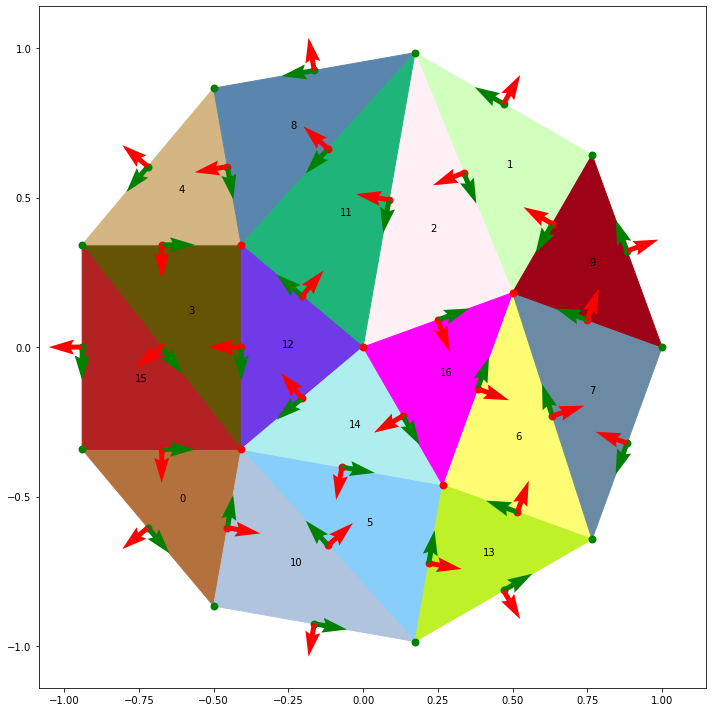

In [181]:
all_colors = (
    list(mcolors.CSS4_COLORS.keys())
    + list(mcolors.XKCD_COLORS.keys())
    + list(mcolors.BASE_COLORS.keys())
)
colors = sample(all_colors, triangles.shape[0])

rot = np.array([
    [+0, +1],
    [-1, +0]
])

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("equal")

for tidx, triangle in enumerate(tqdm(points[triangles])):
    t1 = plt.Polygon(triangle[:3], color=colors[tidx])
    fig.gca().add_patch(t1)
    
    pos = triangle.mean(axis=0)
    ax.text(*pos, f"{tidx}")

    
for idx, point in enumerate(tqdm(points)):
    if vertex_maker_is_boundary[idx] == 0:
        color = "red"
    else:
        color = "green"
        
    ax.scatter(point[0], point[1], color=color, lw=2, s=35)
#     ax.text(point[0], point[1], f"{idx}", size=15)

if True:
    for eidx, edge in enumerate(edges):

        mn = edge.min()
        mx = edge.max()
        mp = points[edge].mean(axis=0)

        T = points[mx] - points[mn]
        T = T / np.linalg.norm(T)
        N = rot @ T

        ax.quiver(*mp, *T, color="green", scale=20)
        ax.quiver(*mp, *N, color="red", scale=20)
        
        pos = points[edge].mean(axis=0)
#         ax.text(*pos, f"{eidx}")
    

ax.set_xlim([points[:, 0].min() - 0.2, points[:, 0].max() + 0.2])
ax.set_ylim([points[:, 1].min() - 0.2, points[:, 1].max() + 0.2])

fig.tight_layout()
plt.tight_layout()

plt.show()

In [182]:
tx = np.linspace(-1.0, 1.0, 1000)
ty = np.linspace(-1.0, 1.0, 1000)
mx, my = np.meshgrid(tx, ty, indexing="ij")

In [183]:
test_fn = (1-x**2-y**2)**2

test_fn_x = sympy.diff(test_fn, x)
test_fn_y = sympy.diff(test_fn, y)

test_fn_xx = sympy.diff(test_fn, x, x)
test_fn_xy = sympy.diff(test_fn, x, y)
test_fn_yy = sympy.diff(test_fn, y, y)

In [184]:
test_fn_vals = np.zeros((points.shape[0], 6))

for point_index, point in enumerate(points):
    
    test_fn_vals[point_index][0] = sympy.lambdify((x, y), test_fn)(*points[point_index])
    
    test_fn_vals[point_index][1] = sympy.lambdify((x, y), test_fn_x)(
        *points[point_index]
    )
    test_fn_vals[point_index][2] = sympy.lambdify((x, y), test_fn_y)(
        *points[point_index]
    )
    test_fn_vals[point_index][3] = sympy.lambdify((x, y), test_fn_xx)(
        *points[point_index]
    )
    test_fn_vals[point_index][4] = sympy.lambdify((x, y), test_fn_xy)(
        *points[point_index]
    )
    test_fn_vals[point_index][5] = sympy.lambdify((x, y), test_fn_yy)(
        *points[point_index]
    )

In [185]:
interpolation = np.zeros_like(mx)
original = np.zeros_like(mx)

points_ = np.stack((mx, my)).transpose(1, 2, 0)

for idx, triangle in enumerate(triangles):
    
    print(f"\rTrinagle {idx}", end="", sep="")

    CURRENT_BASIS, p_idx = transform_basis(points, triangles, idx)
    
    t_points = points[p_idx][:3]

    a = t_points[1] - t_points[0]
    b = t_points[2] - t_points[0]

    areas = np.abs(a[0] * b[1] - a[1] * b[0])

    a = points_[...,] - t_points[0, None, None]
    b = points_[...,] - t_points[1, None, None]
    c = points_[...,] - t_points[2, None, None]

    area1 = np.abs(a[..., 0] * b[..., 1] - a[..., 1] * b[..., 0])
    area2 = np.abs(a[..., 0] * c[..., 1] - a[..., 1] * c[..., 0])
    area3 = np.abs(b[..., 0] * c[..., 1] - b[..., 1] * c[..., 0])
    indices = np.where(np.isclose((area1 + area2 + area3), areas))

    on_1 = sympy.Float(0)
    on_2 = sympy.Float(0)
    on_3 = sympy.Float(0)

    #   U
    on_1 += CURRENT_BASIS[0] * test_fn_vals[p_idx[0]][0]
    on_2 += CURRENT_BASIS[1] * test_fn_vals[p_idx[1]][0]
    on_3 += CURRENT_BASIS[2] * test_fn_vals[p_idx[2]][0]

    #   U_x
    on_1 += CURRENT_BASIS[3] * test_fn_vals[p_idx[0]][1]
    on_2 += CURRENT_BASIS[4] * test_fn_vals[p_idx[1]][1]
    on_3 += CURRENT_BASIS[5] * test_fn_vals[p_idx[2]][1]

    #   U_y
    on_1 += CURRENT_BASIS[6] * test_fn_vals[p_idx[0]][2]
    on_2 += CURRENT_BASIS[7] * test_fn_vals[p_idx[1]][2]
    on_3 += CURRENT_BASIS[8] * test_fn_vals[p_idx[2]][2]

    #   U_xx
    on_1 += CURRENT_BASIS[9] * test_fn_vals[p_idx[0]][3]
    on_2 += CURRENT_BASIS[10] * test_fn_vals[p_idx[1]][3]
    on_3 += CURRENT_BASIS[11] * test_fn_vals[p_idx[2]][3]

    #   U_xy
    on_1 += CURRENT_BASIS[12] * test_fn_vals[p_idx[0]][4]
    on_2 += CURRENT_BASIS[13] * test_fn_vals[p_idx[1]][4]
    on_3 += CURRENT_BASIS[14] * test_fn_vals[p_idx[2]][4]

    #   U_yy
    on_1 += CURRENT_BASIS[15] * test_fn_vals[p_idx[0]][5]
    on_2 += CURRENT_BASIS[16] * test_fn_vals[p_idx[1]][5]
    on_3 += CURRENT_BASIS[17] * test_fn_vals[p_idx[2]][5]

    #   U_n
    t1 = t_points[2] - t_points[1]
    t1 = t1 / np.linalg.norm(t1)
    n1 = rot @ t1
    t2 = t_points[2] - t_points[0]
    t2 = t2 / np.linalg.norm(t2)
    n2 = rot @ t2
    t3 = t_points[1] - t_points[0]
    t3 = t3 / np.linalg.norm(t3)
    n3 = rot @ t3
    
    AAA = n1[0]*sympy.lambdify((x, y), test_fn_x)(*points[p_idx[3]]) + n1[1]*sympy.lambdify((x, y), test_fn_y)(*points[p_idx[3]])
    BBB = n2[0]*sympy.lambdify((x, y), test_fn_x)(*points[p_idx[4]]) + n2[1]*sympy.lambdify((x, y), test_fn_y)(*points[p_idx[4]])
    CCC = n3[0]*sympy.lambdify((x, y), test_fn_x)(*points[p_idx[5]]) + n3[1]*sympy.lambdify((x, y), test_fn_y)(*points[p_idx[5]])
    
    on_1 += CURRENT_BASIS[18] * AAA
    on_2 += CURRENT_BASIS[19] * BBB
    on_3 += CURRENT_BASIS[20] * CCC
    
    total = on_1 + on_2 + on_3

    F = sympy.lambdify((x, y), total)

    MZ = F(mx, my)

    if isinstance(MZ, (int, float)):
        MZ = np.zeros_like(mx) + MZ

    interpolation[indices] = MZ[indices]
    original[indices] = sympy.lambdify((x, y), test_fn)(mx, my)[indices]

Trinagle 16

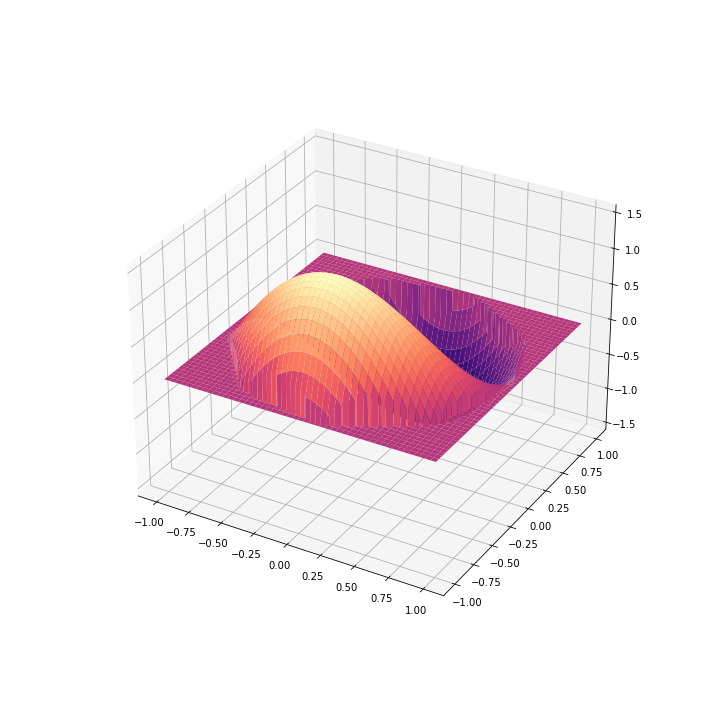

In [186]:
%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.plot_surface(mx, my, interpolation, cmap="magma")
# ax.set_box_aspect((np.ptp(mx), np.ptp(my), np.ptp(interpolation)))
plt.show()